## References
- [Keras neural_style_transfer example](https://github.com/fchollet/keras/blob/master/examples/neural_style_transfer.py)
- [AI Artist](https://github.com/llSourcell/AI_Artist/blob/master/Network.py)

## Dependency
- needs [vgg16 model weights](https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing
(source: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)

## Idea
1. ***Images***: three images
    - result image: the image to be generated
    - style image: image contributing style (will talk about that in details later) to the result
    - content image: image contributing content to the result
2. ***Objectives***: three images will be represnted as variables, and the result image will be generated by optimizing a combination of objective functions, i.e.,
    - style loss: measures how different the styles of result and style image are. The style difference is defined as the `l2` norm of certain representation of style and result images
    - content loss:
    - total variation loss:
3. ***Representations***: above loss functions depend on representations of images. Raw pixel may not be good enough to caputre "styles", "similarities" and etc. So the objectives will be based on features from a image network, namely vgg16.

In [1]:
%matplotlib inline

In [2]:
import keras
keras.__version__

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 980M (CNMeM is disabled, cuDNN 5005)


'1.0.6'

In [3]:
#from scipy.misc import imread, imresize, imsave
## use skimage imread because we want to read image from URL
## otherwise you can just use scipy.misc.imread/imresize/imwrite for local images
from skimage.io import imread, imsave
from skimage import img_as_ubyte, img_as_float
from skimage.transform import resize
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

In [4]:
from keras import models, layers
from keras import backend as K

## load content_image, style_image
- style image is from Chinese painting

In [5]:
style_image = imread("http://www.artisoo.com/images/landscape/cnag220349.jpg")
content_image = imread("http://jrforasteros.com/wp-content/uploads/2010/02/Mountain-Tree.jpg")

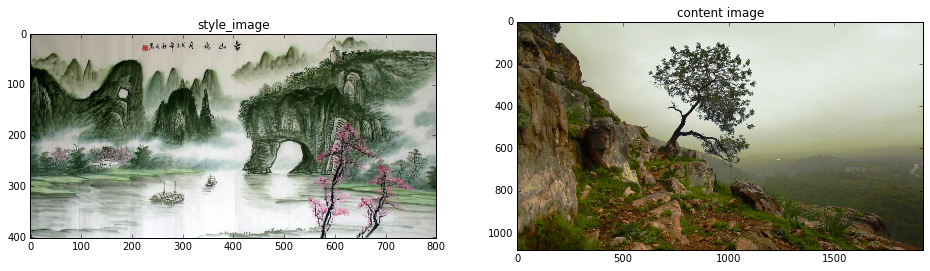

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
fig.subplots_adjust(wspace = 0.2, hspace = 0)
axes[0].imshow(style_image)
axes[0].set_title("style_image")
axes[1].imshow(content_image)
axes[1].set_title("content image")

## encode and decode images
- for images to be used by vgg16, it needs to be encoded, including
    - make sure the color channel is BGR
    - transpose image repr from (width, height, ncolors) to (ncolors, width, height) - this is the theano format that was used to train the vgg16 in the first place
    - extend the dimension to make images (or a single image) a batch of images of shape (nimages, nchannels, width, height). This is the format accepted by vgg16 and keras image models in general
    - resize image width and height to be equal - needed by Gram matrix in definition of objective function
    - substract each color channel for vgg16, see [discussion](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)
    ```python
    im[:,:,0] -= 103.939 # G channel
    im[:,:,1] -= 116.779 # B
    im[:,:,2] -= 123.68 # R
    ```

In [29]:
def encode(img, img_width = 400, img_height = 400):
    ## resize images
    assert img_width == img_height, "square image required by Gram matrix"
    img = resize(img, (img_width, img_height))
    ## convert to ubyte to make sure pixel range in 0 to 255
    img = img_as_ubyte(img).astype("float32")
    ## RGB to BGR
    img = img[:, :, ::-1]
    ## mean centerization
    img[:,:,0] -= 103.939
    img[:,:,1] -= 116.779
    img[:,:,2] -= 123.68
    ## theano format: (color, width, height)
    img = img.transpose((2, 0, 1))
    ## make it a single element batch
    img = np.expand_dims(img, axis = 0)
    return img

def decode(img):
    ## (color, w, h) => (w, h, color)
    img = img.transpose((1, 2, 0))
    ## BGR to RGB
    img = img[:, :, ::-1]
    ## make sure pixel range in 0 to 255
    img = np.clip(img, 0, 255.).astype(np.ubyte)
    return img

(3, 400, 400)


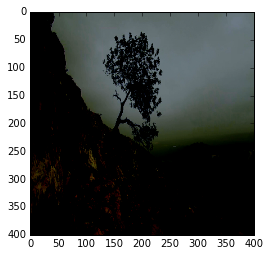

In [34]:
encoded_content_img = encode(content_image)
decoded_content_img = decode(encoded_content_img[0])
plt.imshow(decoded_content_img)